In [224]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Bifurcations de populations de neurones
======================

Le but de ce projet est de simuler l'évolution de l'activité moyenne de groupes de neurones en intéraction, à l'aide d'un modèle simplifié de *Wilson-Cowan*. En notant $x=(x_1,...,x_i,..., x_n)\in \mathbb{R}^n$ le vecteur contenant l'activité moyenne de chacun des $n$ groupes de neurones, ce modèle s'écrit (en grandeurs normalisées)
$$
\tau \dot x = - x + S(Wx + d^{\rm ext})
$$
où $\tau$ est une constante de temps, $W \in \mathbb{R}^{n\times n}$ est une matrice décrivant les intéractions entre groupes de neurones, $d^{\rm ext}\in \mathbb{R}^n$ peut contenir des stimulis/perturbations extérieurs impactant chaque groupe, et $S: \mathbb{R}^n \to \mathbb{R}^n$ est de la forme
$$
S({\rm x}_1,...,{\rm x}_i ,...,{\rm x}_n) = (s_1({\rm x}_1),...,s_i({\rm x}_i),...,s_n({\rm x}_n))
$$
où $s_i:\mathbb{R}\to \mathbb{R}$ sont des fonctions dîtes d'*activation*.

Ces fonctions d'activation permettent de modéliser le fait que l'activité environnante d'un groupe de neurone doit atteindre un certain seuil avant d'exciter ce groupe. Des choix courants de fonctions d'activation sont la tangente hyperbolique ou des sigmoides de la forme
$$
s({\rm x}) = \frac{1}{1+ e^{-a(x-\theta)}}-\frac{1}{1+e^{a\theta}}
$$
où $\theta$ représente le seuil d'activation et $a$ sa pente, comme illustré ci-dessous. 

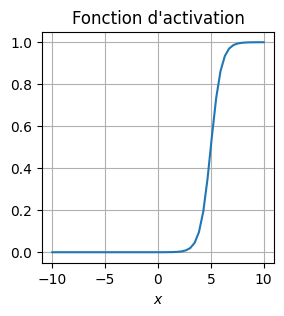

In [225]:
def sigmoid(x):
    a = 2.0   # la pente au niveau du seuil est a/4
    theta = 5.0  # seuil
    return 1/(1+np.exp(-a*(x-theta)))-1/(1+np.exp(a*theta))

x = np.linspace(-10,10)
plt.figure()
plt.plot(x,sigmoid(x))
plt.grid(True)
plt.xlabel('$x$')
plt.title("Fonction d'activation")
plt.show()

Notons que si l'on réécrit l'équation différentielle composante par composante, on trouve que la dynamique de chaque groupe de neurone s'écrit
$$
\tau \dot x_i = -x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)
$$

**Question 1** Justifier que si les fonctions d'activation $s_i:\mathbb{R}\to \mathbb{R}$ sont bornées (minorées et majorées) alors toutes les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$ et sont bornées en temps positif. Relier la borne de $t\mapsto x_i(t)$ à la borne de $s_i$ pour chaque $i$. 



**Question 1 :**  
\
Considérons l'équation :
$$
\tau \dot x = - x + S(Wx + d^{\rm ext})
$$
**Cas 1 :** $\tau \ne 0$ :
$$
\dot x = (- x + S(Wx + d^{\rm ext}))\frac{1}{\tau}
\\
\\
\lVert \dot x \rVert = \lVert (- x + S(Wx + d^{\rm ext}))\frac{1}{\tau} \rVert
\\
\\
\lVert \dot x \rVert = \frac{1}{\tau} \lVert (- x + S(Wx + d^{\rm ext}))\rVert
\\
\\
\lVert \dot x \rVert \le \frac{1}{\tau} \lVert  x \rVert + \frac{1}{\tau} \lVert (S(Wx + d^{\rm ext}))\rVert
$$

Or, on s'est placé dans le cas où les $s_i$ sont bornés. Ainsi, on en déduit que S est aussi bornée avec un majorant que l'on nommera M. Ce qui implique :

$$
\lVert (S(Wx + d^{\rm ext}))\rVert \le M
$$
 
D'où :

$$
\lVert \dot x \rVert \le \frac{1}{\tau} \lVert  x \rVert + M
$$

Ainsi, la fonction considérée rentre dans le cadre du critère d'existence globale, nous permettant de dire que les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$.

**Cas 2 :** $\tau = 0$

La fonction devient :
$$
0 = - x + S(Wx + d^{\rm ext})
\\
\\
x = S(Wx + d^{\rm ext})
\\
\\
\lVert x \rVert = \lVert S(Wx + d^{\rm ext}) \rVert
$$

De la même manière que précédemment, on a S bornée par M donc on a :

$$
\lVert x \rVert \le M
$$

D'où l'existence des solutions maximales sur $\mathbb{R}$, selon le même critère qu'utilisé précédemment.

*D'après Papon on a forcément $\tau \ne 0$*

*D'après Papon passer par l'absurde comme on voulait faire pour montrer qu'elle est bornée*




Pour simplifier, on étudie ce système en dimension 2, c'est-à-dire avec deux groupes de neurones: le premier ayant un effet *excitant* et le deuxième *inhibant*. On traduit cela par la matrice d'interconnection suivante.

In [226]:
W = np.array([[5.0, -4.0], [8.0, -1.0]])
print(W)

[[ 5. -4.]
 [ 8. -1.]]


On fixe aussi $s_1=s_2$ données par la sigmoide ci-dessus, ainsi que $\tau=1$ puisque faire varier $\tau$ ne change que l'échelle de temps. On va essayer d'étudier et exploiter la grande richesse de comportements asymptotiques possibles pour différentes valeurs de $d^{\rm ext}$.

Points d'équilibre
================

On commence par considérer $d^{\rm ext}$ constant. Ses composantes $d_1^{\rm ext}$ et $d_2^{\rm ext}$ peuvent donc être vus comme des paramètres du système. Les points d'équilibre $x^{\rm eq}\in \mathbb{R}^n$ se caractérisent alors par l'équation
$$
x^{\rm eq} = S(W x^{\rm eq} + d^{\rm ext})
$$
La fonction suivante trace les points $(x_1,x_2)$ tels que $-x_1+s(w_{11}x_1+w_{12}x_2+d_1^{\rm ext})=0$ (en rouge) et $-x_2+s(w_{21}x_1+w_{22}x_2+d_2^{\rm ext})=0$ (en vert) pour des valeurs de $d^{\rm ext}$ à choisir.

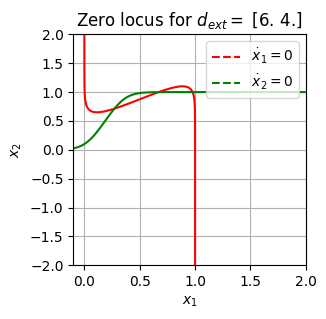

In [227]:
def plot_zero_locus(d_ext):
    grid_x1 = np.linspace(-0.1,2.0,100)
    grid_x2 = np.linspace(-2.0,2.0,100)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    plt.figure()
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()
    return


d_ext = np.array([6.0,4.0])  # A CHOISIR
plot_zero_locus(d_ext)

**Question 2** Identifier le point d'équilibre du système pour $d^{\rm ext}=0$ et étudier sa stabilité. 

**Question 3** Tester d'autres valeurs de $d^{\rm ext}$. Par exemple, fixer $d^{\rm ext}_2=4$, et faire varier $d^{\rm ext}_1$ entre 3 et 8. Qu'observe-t-on sur le nombre de points d'équilibre ? Pour $d^{\rm ext}=(6,4)$, on trace ci-dessous le portrait de phase. Retrouver graphiquement les points d'équilibre et intuiter leur stabilité. Quels sont les seuls comportements asymptotiques possibles des solutions pour cette valeur constante de $d^{\rm ext}$ ?

**Question 2 :** 
\
\
Pour $d^{\rm ext}=0$, le seul point correspondant à $\dot x = ( \dot x_1 , \dot x_2) =(0,0)$ est le point d'intersection de la courbe rouge, correspondant à $\dot x_1 =0$ et de la courbe verte, correspondant à $\dot x_2 =0$ ; qui semble être le point (0,0). 
\
Ainsi, pour $d^{\rm ext}=0$ , le graphique obtenu par exécution de la fonction plot_zero_locus montre qu'il existe un unique point d'équilibre du système, qui semble être le point (0,0).
\
Montrons que $x^{\rm eq}=(0,0)$ est bien un point d'équilibre :
\
On a $S(Wx^{\rm eq}+d^{\rm ext})=S((0,0))=(s(0),s(0))=(0,0)=x^{\rm eq}$ où s est la sigmoïde définie précédemment.
\
Donc $x^{\rm eq}$ est un point d'équilibre.
On en déduit donc que l'unique point d'équilibre est (0,0).

Etudions la stabilité de ce point d'équilibre :
\
On définit f : $x\mapsto -x +S(Wx)$ , c'est-à-dire telle que $\dot x =f(x)$ lorsque $d^{\rm ext}=0$
\
$f((x_1,x_2))=(-x_1+s(5x_1-4x_2), -x_2+s(8x_1-x_2))$
\
Calculons la jacobienne de f au point (0, 0)
\
$
  J_f(x)=
  \left[ {\begin{array}{cc}
    \frac{\partial f_1}{\partial x_1}(x) & \frac{\partial f_1}{\partial x_2}(x) \\
    \frac{\partial f_2}{\partial x_1}(x) & \frac{\partial f_2}{\partial x_2}(x) \\
  \end{array} } \right]
$
\
$
  J_f(x)=
  \left[ {\begin{array}{cc}
    -1+5s'(5x_1-4x_2) & -4s'(5x_1-4x_2) \\
    8s'(8x_1-x_2) & -1-s'(8x_1-x_2) \\
  \end{array} } \right]
$
\
Donc 
\
$
  J_f((0,0))=
  \left[ {\begin{array}{cc}
    -1+5s'(0) & -4s'(0) \\
    8s'(0) & -1-s'(0) \\
  \end{array} } \right]
$

**Montrer que les parties réelles des VP de la jacobienne sont négatives suffit (retrouver le théorème)**

**Suggestion pour la stabilité**

Utilisons les fonctions de lyapunov :

On définit f : $x\mapsto -x +S(Wx)$ , c'est-à-dire telle que $\dot x =f(x)$ lorsque $d^{\rm ext}=0$

Après calcul, on a $s'(x) = \frac{ae^{-a(x-\theta)}}{(1+e^{-a(x-\theta)})^2}$ . Ainsi, on en déduit que la fonction s est $C^1$ sur $\mathbb{R}$ car les dénominateurs de s et s' ne s'annulent jamais et les numérateurs et dénominateurs des deux expressions sont composés de fonctions $C^1$. 

On a d'autre part, la fonction s' qui est strictement positive. Ainsi, on en déduit que la fonction s est croissante sur $\mathbb{R}$, ainsi si on a $f(0) = 0$ et si $s(Wx) > x$ pour $x > 0$ et si on a $s(Wx) < x$ pour $x < 0$ alors on a $f(x)>0$   $\forall x \ne x^{\rm eq}$.

D'autre part, par définition, on a $f(x^{\rm eq})=0$

Enfin, si on a $\frac{\mathrm{d} f}{\mathrm{d} t}\leqslant 0$, on peut conclure :

Le point $x^{\rm eq}$ est un point d'équilibre stable et si on a $\frac{\mathrm{d} f}{\mathrm{d} t} < 0$ alors ce point d'équilibre est localement asymptotiquement stable. Enfin, si on a $\lim_{\left \| x \right \|\rightarrow +\infty} f(x) = +\infty$ alors le point d'équilibre est globalement asymptotiquement stable. 


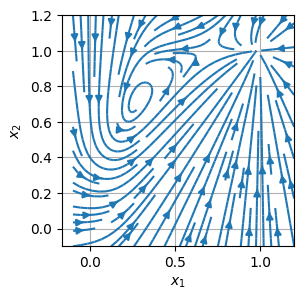

In [228]:
d_ext = np.array([6.0,4.0])  

grid_x1 = np.linspace(-0.1,1.2,70)
grid_x2 = np.linspace(-0.1,1.2,70)
X1, X2 = np.meshgrid(grid_x1,grid_x2)

X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

plt.figure()
plt.streamplot(grid_x1, grid_x2, X1dot, X2dot)
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

**Question 3 :** 
\
\
On remarque que pour $d^{\rm ext}=(3,4)$, on semble toujours avoir un unique point d'équilibre à (0,0). Puis lorsqu'on augmente légèrement $d^{\rm ext}_1$, ce point d'équilibre reste unique et se décale un peu vers le haut et vers la droite ($x^{eq}_1$ et $x^{eq}_2$ augmentent).
Ensuite, tandis que ce point d'équilibre continue d'être décalé, 2 nouveaux point d'équilibre apparaissent, dont le point (1,1). On a alors 3 points d'équilibre. Puis en augmentant encore $d^{\rm ext}_1$, il ne reste plus qu'un unique point d'équilibre : le point (1,1).
\
Pour $d^{\rm ext}=(6,4)$, on observe sur le portrait de phase la présence de 3 points singuliers qui correspondent aux 3 points d'équilibre : *(j'en vois que 2 : (0,25 ; 0,7) et (1 ; 1)   où est le $3^e$?)*

*D'autre part, ces points d'équilibre semblent localement asymptotiquement stables. Ainsi pour cette valeur de $d^{\rm ext}$, on en déduit que toutes les solutions vont converger vers l'un ou l'autre de ces points d'équilibre.*

Lorsque le nombre et la nature (stabilité) des points d'équilibre changent brusquement avec des modifications de paramètres, on parle de *bifurcation*. De tels phénomènes permettent généralement de produire des comportements asymptotiques extrêmement riches et variés, simplement en faisant varier ces paramètres. Nous en étudions plusieurs exemples dans la suite.

Simulation des trajectoires
================

**Question 4** Compléter la fonction ``solve_euler_explicit`` ci-dessous prenant en entrée une fonction $f: \mathbb{R}\times\mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant e vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$.

In [229]:
'''def solve_euler_explicit(f, x0, dt, t0, tf):
    j=0
    xi=x0
    t = np.arange(t0, tf, dt)
    e=np.zeros(len(t))
    e[0]=(t[0],x0)
    while j < len(t):
        xi = xi + dt*f(t[j],xi)
        j+=1
        e[j]=(t[j],xi)
    return e
'''

'def solve_euler_explicit(f, x0, dt, t0, tf):\n    j=0\n    xi=x0\n    t = np.arange(t0, tf, dt)\n    e=np.zeros(len(t))\n    e[0]=(t[0],x0)\n    while j < len(t):\n        xi = xi + dt*f(t[j],xi)\n        j+=1\n        e[j]=(t[j],xi)\n    return e\n'

In [230]:
def solve_euler_explicit(f, x0, dt, t0, tf):
    iter = int((tf-t0)/dt)+1
    time=[t0+k*dt for k in range (iter)]
    e = [x0]
    for t in time[:-1]:
        e.append(x0+dt*f(t, x0))
        x0+=dt*f(t,x0)
    if ((tf-t0)%dt)!=0:
        x0+=((tf-t0)%dt)*f(time[len(time)-1], x0)
        time.append(tf)
        e.append(x0)
    return (time, e)

**Question 5** Expliquer (sans le faire) comment on pourrait trouver numériquement l'ordre de convergence de ce schéma.


**Question 5 :**


**Question 6** On utilise maintenant ``solve_euler_explicit`` pour simuler des trajectoires de neurones lorsque $d^{\rm ext}$ est constant. En vous aidant du portrait de phase de la question 3, illustrer les comportements asymptotiques possibles des solutions pour $d^{\rm ext}=(6,4)$, en choisissant différentes conditions initiales. Lequel ne peut-on pas illustrer numériquement ?

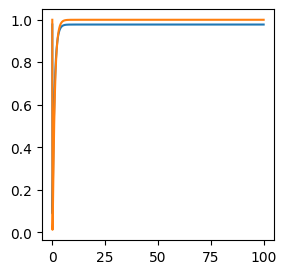

In [231]:
def f_d_ext_constant(t,x):
    d_ext = np.array([6.0,4.0])
    return -x + sigmoid(np.dot(W,x)+d_ext)

x0 = np.array([0,0], dtype = 'float64') # A COMPLETER
dt = 0.1
t0, tf = 0.0, 100.0
time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)

plt.figure()
plt.plot(time,x)

**Question 6 :**
\
3 comportement asymptotiques possibles selon les conditions initiales : 
\
Une convergence vers $x_1\approx(0.25 , 0.7)$, pour des conditions initiales telles que $x_0=(0.5,1)$
\
Une convergence vers $x_2=(1,1)$, pour des conditions initiales telles que $x_0=(0,0)$
\
Et une convergence vers $x_3\approx(0.75,1)$ si la condition initiale est exactement $x_0=(0.75,1)$. Ce dernier cas de figure ne peut pas être illustré numériquement car la précision numérique n'est pas suffisante pour que la condition initiale soit exactement $x_0=(0.75,1)$ et les solutions vont donc basculer vers l'un ou l'autre des points attractif puisque (0.75,1) est un point d'équilibre instable.

**Question 7** On fixe maintenant $d_2^{\rm ext}=8$ et on fait varier $d_1^{\rm ext}$ lentement de 4 à 8, puis de 8 à 4. En utilisant ``plot_zero_locus``, justifier le comportement de la solution obtenue. Tracer la solution en fonction de $d_1^{\rm ext}$, comment appelle-t-on ce phénomène ? Justifier que l'on parle de *mémoire courte*.

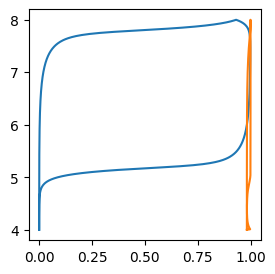

In [232]:
def d_ext_varying(t):
    d1_ext = (0.1*t+4)*(t<40)+(8-0.1*(t-40))*(t>=40)
    d2_ext = 8.0*np.ones(np.shape(t))
    return np.array([d1_ext,d2_ext])

def f_d_ext_varying(t,x):
    return -x + sigmoid(np.dot(W,x)+d_ext_varying(t))

x0 = np.array([0.0,1.0])
dt = 0.1
t0, tf = 0.0, 80.0
time, x = solve_euler_explicit(f_d_ext_varying, x0, dt, t0, tf)
d_ext=[d_ext_varying(t) for t in time]
d1_ext=[d_ext[i][0] for i in range(len(d_ext))]

plt.figure()
plt.plot(x,d1_ext)

**Question 7 :**

Bendixon et cycle limite
============================

On cherche maintenant à faire apparaître un cycle limite oscillatoire. On s'appuie pour cela sur le théorème de *Bendixon* qui décrit le comportement possible de solutions bornées d'équations différentielles en dimension 2:

    ''Pour une équation différentielle de dimension 2 définie par une fonction continument différentiable, toute solution maximale bornée converge soit vers un point soit vers une fonction périodique du temps appelée *cycle limite*''
    
**Question 8** Justifier que l'on recherche alors une valeur de $d_{\rm ext}$ pour laquelle le système admet un seul point d'équilibre et pour laquelle ce point est instable. 

**Question 9** La fonction ci-dessous permet de tracer les zéros de la dynamique comme ci-dessus mais superposés aux zones où la trace de la jacobienne de $f$ est strictement négative et son déterminant strictement positif. Compléter le calcul de la jacobienne et proposer une méthode empirique pour trouver une valeur de $d_{\rm ext}$ donnant un cycle limite. Vérifier en simulation l'apparition de ce cycle limite.

**Question 8 :**
\
\
ghg

In [233]:
def jacobian_dynamics(x1,x2,d_ext):
    return # A COMPLETER

def plot_zero_locus_stabilite(d_ext):
    N = 100
    grid_x1 = np.linspace(-0.1,2.0,N)
    grid_x2 = np.linspace(-2.0,2.0,N)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    # compute trace and determinant of jacobian matrix on the grid
    tr = np.zeros((N,N))
    deter = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            tr[i,j] = np.trace(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))
            deter[i,j] = np.linalg.det(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))

    # plot zone where  the trace of the jacobian is negative and its determinant positive
    plt.figure()
    plt.pcolormesh(X1,X2,(tr<0)*(deter>0))

    # root locus plot
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()

    return

plot_zero_locus_stabilite(np.array([4.0,1.0]))

ValueError: diag requires an array of at least two dimensions

**Question 9 :**
\
\
lkj